In [73]:
import pandas as pd
import os
import glob
import numpy as np
from snorkel.labeling.model import LabelModel, MajorityLabelVoter
from sklearn.metrics import classification_report

def reorder_columns(df, cols_in_front):
    """Reorder columns in a pandas dataframe so that the columns in cols_in_front are in front.
    """
    columns = list(df.columns)
    for col in cols_in_front:
        columns.remove(col)
    columns = cols_in_front + columns
    return df[columns]

def lf_results_reported(path='./CITT/'):
    df = pd.read_csv(path + 'calculated_values.txt', sep='|', low_memory=False)
    df['lf'] = df['were_results_reported'] == 't'
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_num_sponsors(path='./CITT/'):
    df = pd.read_csv(path + 'sponsors.txt', sep='|')
    df = df.groupby('nct_id')['name'].count().reset_index()
    df['lf'] = df['name'] > df['name'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_num_patients(path='./CITT/'):
    df = pd.read_csv(path + 'outcome_counts.txt', sep='|', low_memory=False)    
    df = df.groupby('nct_id').sum().reset_index() # pd df (NCTID, values, num_patients)
    df['lf'] = df['count'] > df['count'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_patient_drop(path='./CITT/'):
    # patient dropout
    df = pd.read_csv(os.path.join(path, 'drop_withdrawals.txt'), sep='|')
    df = df.groupby('nct_id').sum().reset_index() # pd df (NCTID, values, patient_drop)
    df['lf'] = df['count'] < df['count'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_sites(path='./CITT/'):
    # sites
    df = pd.read_csv(os.path.join(path, 'facilities.txt'), sep='|')
    df = df.groupby('nct_id')['name'].count().sort_values(ascending=False).reset_index()
    df = df.groupby('nct_id').mean().reset_index() # pd df (NCTID, values, sites)
    df['lf'] = df['name'] > df['name'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_pvalues(path='./CITT/'):
    # pvalues
    path = './CITT/'
    df = pd.read_csv(os.path.join(path, 'outcome_analyses.txt'), sep='|', low_memory=False)
    df['lf'] = df['p_value'] < .05 # 89406
    df = df.groupby('nct_id')[['lf', 'p_value']].mean().reset_index() # multiple pvalues per nct_id
    df['lf'] = df['lf'] > df['lf'].quantile(.5) 
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_update_more_recent(path='./CITT/'): #TODO clarify what this does
    df = pd.read_csv(os.path.join(path, 'studies.txt'), sep='|', low_memory=False)
    df['last_update_submitted_date'] = pd.to_datetime(df['last_update_submitted_date'])
    df['completion_date'] = pd.to_datetime(df['completion_date'])
    df['update_days'] = (df['last_update_submitted_date'] - df['completion_date']).dt.days
    median = df['update_days'].median()
    # print(median)
    df['lf'] = df['update_days'].apply(lambda x: x > median if pd.notna(x) else x)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf']) 
    return df

def lf_death_ae(path='./CITT/'):
    df = pd.read_csv(path+'reported_event_totals.txt', sep = '|')
    df = df[df['event_type'] == 'deaths'].fillna(0)
    df = df.groupby('nct_id')['subjects_affected'].sum().reset_index()
    df['lf'] = df['subjects_affected'] < df['subjects_affected'].quantile(.5)
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_serious_ae(path='./CITT/'):
    df = pd.read_csv(path+'reported_event_totals.txt', sep = '|')
    df = df[df['event_type'] == 'serious'].fillna(0)
    df = df.groupby('nct_id')['subjects_affected'].sum().reset_index()
    df['lf'] = df['subjects_affected'] < df['subjects_affected'].quantile(.5)
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_all_ae(path='./CITT/'):
    df = pd.read_csv(path+'reported_event_totals.txt', sep = '|').fillna(0)
    df = df.groupby('nct_id')['subjects_affected'].sum().reset_index()
    df['lf'] = df['subjects_affected'] < df['subjects_affected'].quantile(.5)
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_status(path='./CITT/'):
    df = pd.read_csv(path+'studies.txt', sep='|')
    df['lf'] = -1
    df.loc[df['overall_status'].isin(['Terminated', 'Withdrawn', 'Suspended', 'Withheld', 'No longer available', 'Temporarily not available']),['lf']] = 0
    df.loc[df['overall_status'].isin(['Approved for marketing']),['lf']] = 1
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_amendments(path='./stock_price/labels_and_tickers.csv'):
    df = pd.read_csv(path)
    df['lf'] = df['amendment_counts'] > df['amendment_counts'].quantile(.5)
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df
    
def lf_stock_price(path='./stock_price/labels_and_tickers.csv'):
    df = pd.read_csv(path)
    df['lf'] = df['Slope'] > 0
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df
    
def lf_linkage(path='./Trial Linkage/Merged_(ALL)_trial_linkage_outcome_df_FDA_updated.csv'):
    # df1 = pd.read_csv(path+'Extracted trial outcomes/Phase 1_Early Phase 1_trial_linkage_outcome_df.csv')
    # df2 = pd.read_csv(path+'Extracted trial outcomes/Phase 2_Phase 1_Phase 2_trial_linkage_outcome_df.csv')
    # df3 = pd.read_csv(path+'Extracted trial outcomes/Phase 3_Phase 2_Phase 3_trial_linkage_outcome_df.csv')
    # df = pd.concat([df1, df2, df3])
    # df.rename(columns={'Unnamed: 0': 'nct_id'}, inplace=True)
    df = pd.read_csv(path)
    df.rename(columns={'nctid': 'nct_id'}, inplace=True)
    df['lf'] = 0
    df.loc[df['outcome']=='Not sure',['lf']] = 1
    df.loc[df['outcome']=='Success', ['lf']] = 1
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_news_headlines(path='./stock_price/studies_with_news.csv'):
    df = pd.read_csv(path)
    df['lf'] = df['top_1_sim'] > 0
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df
           
def lf_gpt(path='./Trial Linkage/pubmed_gpt_outcomes.csv'):
    df = pd.read_csv(path)
    df['outcome'].unique()
    df['lf'] = -1
    df.loc[df['outcome']=='Success', ['lf']] = 1
    df.loc[df['outcome']=='Not sure',['lf']] = 1           
    df.loc[df['outcome']=='Failure', ['lf']] = 0
    df.rename(columns={'nctid': 'nct_id'}, inplace=True)           
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def get_lfs(path='./CITT/'):
    dfs = [lf_results_reported(path=path), 
           lf_num_sponsors(path=path),
           lf_num_patients(path=path), 
           lf_patient_drop(path=path), 
           lf_sites(path=path), 
           lf_pvalues(path=path),
           lf_update_more_recent(path=path),
           lf_death_ae(path=path),
           lf_serious_ae(path=path),
           lf_all_ae(path=path),
           lf_status(path=path),
           lf_amendments(),
           lf_stock_price(),
           lf_linkage(),
           lf_linkage(),
           lf_news_headlines(),
           lf_gpt(),
           lf_gpt(),
           ]

    all_ids = set() # set of all nct_ids
    for df in dfs:
        all_ids = all_ids | set(df['nct_id'])

    all_df = pd.DataFrame(all_ids, columns=['nct_id']) # combine all dfs
    for i, df in enumerate(dfs):
        all_df = pd.merge(all_df, df.iloc[:,:2].rename(columns={'lf':'lf'+str(i)}), on='nct_id', how='left')
    all_df = all_df.fillna(-1)
    # all_df.iloc[:,1:] = all_df.iloc[:,1:].astype('int')
    return all_df

df = get_lfs()

/tmp/ipykernel_3841990/3148420353.py:108: DtypeWarning: Columns (46,47,48,53,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+'studies.txt', sep='|')
/tmp/ipykernel_3841990/3148420353.py:144: DtypeWarning: Columns (53,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [71]:
# classification report
path = './clinical-trial-outcome-prediction/data/'
all_files = glob.glob(os.path.join(path, "phase*train.csv")) + glob.glob(os.path.join(path, "phase*valid.csv"))
hint = pd.concat((pd.read_csv(f) for f in all_files))
hint.rename(columns={'nctid': 'nct_id'}, inplace=True)
print(hint['label'].value_counts() / hint.shape[0])

label
1    0.555912
0    0.444088
Name: count, dtype: float64


In [74]:
from snorkel.labeling.model import LabelModel, MajorityLabelVoter

# L = np.array([[0, 0, -1], [-1, 0, 1], [1, -1, 0]])
# Y_dev = [0, 1, 0]
df2 = df.copy()
L = df2.iloc[:,1:].values.astype('int')
label_model = LabelModel(verbose=False)
# label_model = MajorityLabelVoter(cardinality=2)
# label_model.fit(L)
# label_model.fit(L, Y_dev=Y_dev, seed=2020, lr=0.05)
# label_model.fit(L, class_balance=[0.44, 0.56], seed=0)
label_model.fit(L, class_balance=[0.5, 0.5], seed=0, lr=0.05, n_epochs=100)
pred = label_model.predict(L)

print('predicted label distribution', np.unique(pred, return_counts=True))
df2['pred'] = pred.astype('int')

for phase in ['phase 1', 'phase 2', 'phase 3']:
    hint_subset = hint[hint['phase'].str.contains(phase)]
    combined = pd.merge(hint_subset, df2, on='nct_id', how='left')
    combined = combined.dropna(subset=['pred'])
    combined = combined[combined['pred'] != -1]
    print(phase, hint_subset.shape, combined.shape)
    report = classification_report(combined['label'], combined['pred'], output_dict=True)
    print(report['1'])
# df.to_csv('lfs.csv', index=False)

100%|██████████| 100/100 [00:03<00:00, 32.83epoch/s]


predicted label distribution (array([0, 1]), array([218355, 261406]))
phase 1 (1596, 10) (1632, 29)
{'precision': 0.5656819610307983, 'recall': 0.9761388286334056, 'f1-score': 0.716275368085953, 'support': 922.0}
phase 2 (5065, 10) (5225, 29)
{'precision': 0.4907987470634299, 'recall': 0.9850687622789784, 'f1-score': 0.6551679080099307, 'support': 2545.0}
phase 3 (3617, 10) (3860, 29)
{'precision': 0.6484517304189436, 'recall': 0.9983974358974359, 'f1-score': 0.7862438870484304, 'support': 2496.0}


In [76]:
df.to_csv('lfs.csv', index=False)

In [ ]:

for phase in ['phase 1', 'phase 2', 'phase 3']:
    hint_subset = hint[hint['phase'].str.contains(phase)]
    combined = pd.merge(hint_subset, df2, on='nct_id', how='left')
    combined = combined.dropna(subset=['pred'])
    combined = combined[combined['pred'] != -1]
    print(phase, hint_subset.shape, combined.shape)
    report = classification_report(combined['label'], combined['pred'], output_dict=True)
    print(report['1'])


In [69]:
names = ['lf_results_reported', 'lf_num_sponsors', 'lf_num_patients', 'lf_patient_drop', 'lf_sites', 'lf_pvalues', 'lf_update_more_recent', 'lf_death_ae', 'lf_serious_ae', 'lf_status', 'lf_all_ae', 'lf_amendments', 'lf_stock_price', 'lf_linkage', 'lf_news_headlines', 'lf_gpt']
print('lf, -1.0, 0.0, 1.0, prop, coverage, f1_phase1, f1_phase2, f1_phase3')
for i in range(0, 14):
    value_counts = df['lf'+str(i+1)].value_counts()
    value_dict = value_counts.to_dict()

    print(names[i], end=',')
    for key in [-1.0, 0.0, 1.0]:
        if key not in value_dict:
            value_dict[key] = 0
        print(value_dict[key], end=',')

    print(value_dict[1.0] / (value_dict[1.0] + value_dict[0.0]), end=',')
    print(sum([value_dict[k] for k in value_dict.keys() if k!=-1.0]) / len(df),end=',')

    # agreement with HINT phase 1,2,3
    for phase in ['phase 1', 'phase 2', 'phase 3']:
        hint_subset = hint[hint['phase'].str.contains(phase)]
        combined = pd.merge(hint_subset, df, on='nct_id', how='left')
        combined = combined[combined['lf'+str(i+1)] != -1]
        # print(combined['lf'+str(i+1)].astype(int).value_counts())
        # if all values are same, skip
        if len(combined['lf'+str(i+1)].unique()) == 1:
            print('0', end=',')
            continue
        report = classification_report(combined['label'], combined['lf'+str(i+1)].astype(int), output_dict=True)
        print(report['1']['f1-score'], end=',')
        # if '1' in report and 'f1_score' in report['1']:
        #     print(report['1']['f1_score'], end=',')
        # else:
        #     print('0', end=',')
    
    print()
# studies = pd.read_csv('./CITT/studies.txt', sep='|')
# studies = studies[studies['study_type'] == 'Interventional']
# studies.completion_date = pd.to_datetime(studies.completion_date)


lf, -1.0, 0.0, 1.0, prop, coverage, f1_phase1, f1_phase2, f1_phase3
lf_results_reported,1,321091,158669,0.3307257795564449,0.9999979156288236,0.3961783439490446,0.3944396177237185,0.368435083977606,
lf_num_sponsors,416844,31074,31843,0.5061112259007899,0.13114238131069428,0.5180467091295117,0.6466841513675534,0.8393726338561385,
lf_num_patients,440904,20028,18829,0.48457163445453844,0.08099241080454643,0.4494949494949495,0.4178047546788063,0.19875776397515527,
lf_patient_drop,50681,313964,115116,0.2682856343805351,0.8943619844047349,0.5564668769716088,0.541421279937181,0.6477349560513861,
lf_sites,457677,11068,11016,0.4988226770512588,0.04603125306142017,0.6046511627906976,0.7093389296956978,0.8394160583941606,
lf_pvalues,16869,230590,232302,0.5018492434520363,0.9648387426239315,0.6717763751127142,0.6351039260969977,0.7795031055900621,
lf_update_more_recent,417048,62713,0,0.0,0.13071716959069205,0,0,0,
lf_death_ae,417048,34899,27814,0.4435125093680736,0.13071716959069205,0.258660508083

name                            0
count                           0
study_first_submitted_date      0
ticker                        862
dtype: int64
                       name  count study_first_submitted_date ticker
0           GlaxoSmithKline   1033                 1999-11-01    NaN
1               AstraZeneca    871                 1999-11-01    AZN
2   Merck Sharp & Dohme LLC    852                 1999-11-01    NaN
3                    Pfizer    819                 1999-11-01    PFE
4  Novartis Pharmaceuticals    735                 2000-04-06    NaN


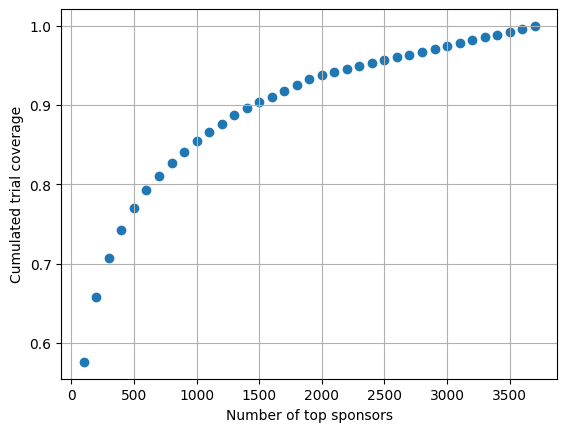

In [111]:
# ============ get top sponsors ============
import pandas as pd
import matplotlib.pyplot as plt

data_path = './CITT/'
sponsors = pd.read_csv(data_path + 'sponsors.txt', sep='|')
studies = pd.read_csv(data_path + 'studies.txt', sep='|', low_memory=False)
ticker_df = pd.read_csv('stock_price/ticker_dict_642.csv')

studies['study_first_submitted_date'] = pd.to_datetime(studies['study_first_submitted_date'])
sponsors = pd.merge(sponsors, studies[['nct_id', 'phase', 'study_first_submitted_date']], on='nct_id', how='left')
sponsors = sponsors[sponsors['agency_class']=='INDUSTRY']
sponsors.dropna(inplace=True)
sponsors = sponsors[sponsors['phase'].str.contains('Phase 3')]
# len(sponsors[sponsors['agency_class']=='INDUSTRY']['name'].unique()) #15277

# top sponsors and their cumulated trial coverage
num_sponsors = []
coverage = []
for i in range(100, len(sponsors['name'].unique()), 100):
    top_sponsors = sponsors['name'].value_counts().head(i)
    coverage_ = top_sponsors.sum() / sponsors['name'].value_counts().sum()
    num_sponsors.append(i)
    coverage.append(coverage_)
plt.scatter(num_sponsors, coverage, label='Cumulated trial coverage')
plt.xlabel('Number of top sponsors')
plt.ylabel('Cumulated trial coverage')
plt.grid()

top_sponsors = sponsors['name'].value_counts().head(1000)
coverage_ = top_sponsors.sum() / sponsors['name'].value_counts().sum()
combined = pd.merge(top_sponsors.reset_index(), sponsors.groupby('name')['study_first_submitted_date'].min().reset_index(), on='name', how='left')
combined = pd.merge(combined, ticker_df, on='name', how='left')
print(combined.isna().sum())
print(combined.head())
# combined.to_csv('top_sponsors.csv', index=False)


In [16]:
import zipfile
import json
import pandas as pd

# with zipfile.ZipFile('./fda_nat_drug_code_dir/ndctext.zip') as zf:
#     print(zf.namelist())
#     with zf.open("product.txt", mode="r") as file:
#         product = pd.read_csv(file, sep='\t', encoding='unicode_escape')
#     with zf.open("package.txt", mode="r") as file:
#         package = pd.read_csv(file, sep='\t', encoding='unicode_escape')
# with zipfile.ZipFile('./fda_nat_drug_code_dir/ndc_unfinished.zip') as zf:
#     print(zf.namelist())
#     with zf.open("unfinished_product.txt", mode="r") as file:
#         product2 = pd.read_csv(file, sep='\t', encoding='unicode_escape')
#     with zf.open("unfinished_package.txt", mode="r") as file:
#         package2 = pd.read_csv(file, sep='\t', encoding='unicode_escape')
# with zipfile.ZipFile('./fda_nat_drug_code_dir/ndc_excluded.zip') as zf:
#     print(zf.namelist())
#     with zf.open("Products_excluded.txt", mode="r") as file:
#         product3 = pd.read_csv(file, sep='\t', encoding='unicode_escape')
#     with zf.open("Packages_excluded.txt", mode="r") as file:
#         package3 = pd.read_csv(file, sep='\t', encoding='unicode_escape')
# with zipfile.ZipFile('./fda_nat_drug_code_dir/compounders_ndc_directory.zip') as zf:
#     print(zf.namelist())
#     with zf.open("compounders_ndc_directory.txt", mode="r") as file:
#         product4 = pd.read_csv(file, sep='\t', encoding='unicode_escape')

with zipfile.ZipFile('./openfda/drug-ndc-0001-of-0001.json.zip') as zf:
    with zf.open("drug-ndc-0001-of-0001.json") as f:
        data = json.load(f)
prod_ndc_dict = pd.DataFrame(data['results']).astype(str)
orange_book = pd.read_csv('./EOBZIP_2024_04/products.txt', sep='~').astype(str)

# remove nonnumeric from application number
prod_ndc_dict['application_number'] = prod_ndc_dict['application_number'].str.replace(r'\D', '', regex=True)

# results = ['Marketing Category, Total, # In Orange Book']
print('Marketing Category, Total, # In Orange Book')
for marketing_category in prod_ndc_dict['marketing_category'].unique():
    a = set(prod_ndc_dict[prod_ndc_dict['marketing_category']==marketing_category]['application_number'])
    # check lenth of overlap with orange book
    l = len([a_ for a_ in a if a_ in set(orange_book['Appl_No'])])
    print(f"{marketing_category}, {len(prod_ndc_dict[prod_ndc_dict['marketing_category']==marketing_category])}, {l}")

Marketing Category, Total, # In Orange Book
ANDA, 47702, 5561
OTC MONOGRAPH NOT FINAL, 9071, 0
NDA AUTHORIZED GENERIC, 1370, 47
OTC MONOGRAPH FINAL, 8962, 0
UNAPPROVED MEDICAL GAS, 322, 0
OTC MONOGRAPH DRUG, 17059, 0
NDA, 7548, 1040
UNAPPROVED DRUG OTHER, 2771, 0
UNAPPROVED HOMEOPATHIC, 13282, 0
BLA, 3773, 0
DRUG FOR FURTHER PROCESSING, 5290, 0
BULK INGREDIENT, 12139, 0
BULK INGREDIENT FOR HUMAN PRESCRIPTION COMPOUNDING, 2011, 0
EXPORT ONLY, 152, 0
UNAPPROVED DRUG FOR USE IN DRUG SHORTAGE, 41, 0
EMERGENCY USE AUTHORIZATION, 12, 0


In [ ]:
# # ================== overlap between drugbank and orangebook ==================
# import pandas as pd
# # df = pd.read_csv('./drugbank_all_drug_links.csv.zip')
# drugbank_approved = pd.read_csv('./drugbank/drugbank_approved_drug_links.csv.zip')

# # exclusivity = pd.read_csv('./EOBZIP_2024_02/exclusivity.txt', sep='~')
# # patent = pd.read_csv('./EOBZIP_2024_02/patent.txt', sep='~')
# products = pd.read_csv('./EOBZIP_2024_02/products.txt', sep='~')
# drug_vocab = pd.read_csv('./drugbank/drugbank vocabulary.csv')

# drugbank_approved['Name'] = drugbank_approved['Name'].str.lower()
# drugbank_approved_names = set(drugbank_approved['Name'].unique())

# products[['Ingredient', 'Trade_Name']] = products[['Ingredient', 'Trade_Name']].apply(lambda x: x.str.lower().str.strip())
# products['Ingredient'] = products['Ingredient'].str.split(';')
# products['Ingredient'] = products['Ingredient'].apply(lambda x: [y.strip() for y in x] if isinstance(x, list) else [])
# unique_ingredients = set(products['Ingredient'].explode().unique())

# products['Trade_Name'] = products['Trade_Name'].str.split(' and ')
# products['Trade_Name'] = products['Trade_Name'].apply(lambda x: [y.strip() for y in x] if isinstance(x, list) else [])
# unique_trade_names = set(products['Trade_Name'].explode().unique())

# drug_vocab['Synonyms'] = drug_vocab['Synonyms'].str.split('|')
# drug_vocab['Synonyms'] = drug_vocab['Synonyms'].apply(lambda x: [y.lower().strip() for y in x] if isinstance(x, list) else [])

# all_synonyms = set(drug_vocab['Synonyms'].explode().dropna().unique())
# common_names = set(drug_vocab['Common name'].str.lower().unique())
# all_names = common_names.union(all_synonyms)

# print('unique_ingredients', len(unique_ingredients)) # 2264
# print(len(unique_ingredients.intersection(all_synonyms))) # 1088
# print(len(unique_ingredients.intersection(common_names))) # 1095
# print(len(unique_ingredients.intersection(all_names))) # 1183

# print('unique_trade_names', len(unique_trade_names)) # 7071
# print(len(unique_trade_names.intersection(all_synonyms))) # 669
# print(len(unique_trade_names.intersection(common_names))) # 629
# print(len(unique_trade_names.intersection(all_names))) # 701

# print('drugbank_approved_names', len(drugbank_approved_names)) # 4389
# print(len(drugbank_approved_names.intersection(unique_ingredients))) # 1074
# print(len(drugbank_approved_names.intersection(unique_trade_names))) # 624

In [ ]:
# import sys
# sys.path.append('./GNews/')
# from gnews import GNews

# google_news = GNews()
# pakistan_news = google_news.get_news('Pakistan')
# print(pakistan_news[0])    


In [ ]:
# import yfinance as yf

# msft = yf.Ticker("MSFT")

# # get all stock info
# msft.info

# # get historical market data
# hist = msft.history(period="1mo")

# # show meta information about the history (requires history() to be called first)
# msft.history_metadata

# # show actions (dividends, splits, capital gains)
# msft.actions
# msft.dividends
# msft.splits
# msft.capital_gains  # only for mutual funds & etfs

# # show share count
# msft.get_shares_full(start="2022-01-01", end=None)

# # show financials:
# # - income statement
# msft.income_stmt
# msft.quarterly_income_stmt
# # - balance sheet
# msft.balance_sheet
# msft.quarterly_balance_sheet
# # - cash flow statement
# msft.cashflow
# msft.quarterly_cashflow
# # see `Ticker.get_income_stmt()` for more options

# # # show holders
# # msft.major_holders
# # msft.institutional_holders
# # msft.mutualfund_holders
# # msft.insider_transactions
# # msft.insider_purchases
# # msft.insider_roster_holders

# # # show recommendations
# # msft.recommendations
# # msft.recommendations_summary
# # msft.upgrades_downgrades

# # Show future and historic earnings dates, returns at most next 4 quarters and last 8 quarters by default. 
# # Note: If more are needed use msft.get_earnings_dates(limit=XX) with increased limit argument.
# msft.earnings_dates

# # # show ISIN code - *experimental*
# # # ISIN = International Securities Identification Number
# # msft.isin

# # # show options expirations
# # msft.options

# # # show news
# # msft.news

# # # get option chain for specific expiration
# # opt = msft.option_chain('YYYY-MM-DD')
# # # data available via: opt.calls, opt.puts

In [ ]:
# import requests # doesn't work
# def get_ticker(company_name):
#     res = requests.get(url="https://query2.finance.yahoo.com/v1/finance/search", 
#                        params={
#                            "q": company_name, 
#                            }, 
#                        headers={
#                            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
#                            }
#                            )
#     data = res.json()
#     return data
#     # print(data)
#     # company_code = data['quotes'][0]['symbol']
#     # return company_code

# data = get_ticker('')
# data.keys() #dict_keys(['explains', 'count', 'quotes', 'news', 'nav', 'lists', 'researchReports', 'screenerFieldResults', 'totalTime', 'timeTakenForQuotes', 'timeTakenForNews', 'timeTakenForAlgowatchlist', 'timeTakenForPredefinedScreener', 'timeTakenForCrunchbase', 'timeTakenForNav', 'timeTakenForResearchReports', 'timeTakenForScreenerField', 'timeTakenForCulturalAssets'])


In [ ]:
# import json

# # with open("./tmp/NCT00102336_pubmed_abs.json", 'r') as f:
# with open("./tmp/NCT00102336_pubmed_abs.json", 'r') as f:
#     d = json.load(f)

# # print(len(d['References']))
# # print(d['References'][0].keys())
# # for i in range(len(d['References'])):
# #     print(i, d['References'][i]['Reference type'])

# prompt = '''
# You are given the PubMed abstract for a clinical trial. Your task is to use summarize important values of the trial into a json format. After summarization, you must predict the trial outcome.

# Guidelines:
# - **Completeness**: Ensure there are no missing statistical tests and descriptions in json output.
# - **Data Verification**: Before concluding the final answer, always verify that your observations align with the original trial description. Do not create any new information.

# Output Format:
# {
#     "description": <string of text summary of the trial outcome>,
#     "extracted features": [
#         {
#         "description: <string, text describing the feature extracted: e.g. "platelet response", "number of participants", "confidence interval", "p-value", "number", "study design">
#         "value": <float or string of the values of above description>
#         }, ... # can repeat as many times as needed
#     ]
#     "outcome": <string, must either "succeed", "fail", "unsure">,
#     "outcome reasoning": <string, reasoning as to why you predicted the outcome. Most trials succeed if the primary p-value < 0.05>
# }

# Notes for final output:
# - Ensure the final answer format is a valid json dictionary. 
# - Ensure all "value" are of float or string ONLY  

# Here is the abstract: 

# [ABSTRACT]

# Begin!
# '''

# abs = d['References'][5]['Abstract']

# print(prompt.replace("[ABSTRACT]", abs))
# # print(prompt)